In [7]:
## Our standard import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

/Users/Alex/opt/anaconda3/envs/dojo-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
y = df['price']
X = df.drop(columns='price')

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
17,0,gas,std,four,sedan,rwd,front,110.0,197.0,70.9,...,6,209,mpfi,3.62,3.39,8.0,182,5400,15,20
39,0,gas,std,four,sedan,fwd,front,96.5,175.4,65.2,...,4,110,1bbl,3.15,3.58,9.0,86,5800,27,33
40,0,gas,std,four,sedan,fwd,front,96.5,175.4,62.5,...,4,110,1bbl,3.15,3.58,9.0,86,5800,27,33
47,0,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,...,6,258,mpfi,3.63,4.17,8.1,176,4750,15,19
123,-1,gas,std,four,wagon,fwd,front,103.3,174.6,64.6,...,4,122,2bbl,3.35,3.46,8.5,88,5000,24,30


In [4]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x112d2a310>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x112d2a2b0>)],
                  verbose_feature_names_out=False)

In [5]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,...,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
48,0.0,113.0,199.6,69.6,52.8,4066.0,6.0,258.0,3.63,4.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
196,-2.0,104.3,188.8,67.2,56.2,2935.0,4.0,141.0,3.78,3.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
148,0.0,96.9,173.6,65.4,54.9,2420.0,4.0,108.0,3.62,2.64,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [8]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_df,y_train)
evaluate_regression(xgb_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 1.00	RMSE= 236.20
Test Data:	R^2= 0.90	RMSE= 2749.60


/Users/Alex/opt/anaconda3/envs/dojo-env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [9]:
feature_importance = pd.Series(xgb_reg.feature_importances_, index=feature_names,
                        name='XGBoost Feature Importances')
feature_importance.head()

symboling    0.001401
wheelbase    0.019486
carlength    0.001908
carwidth     0.002352
carheight    0.001233
Name: XGBoost Feature Importances, dtype: float32

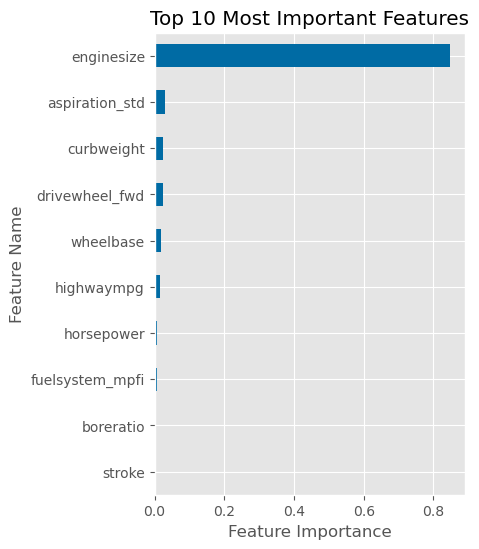

In [10]:
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

- The 5 most important features were: enginesize, aspiration_std, curbweight, drivewheel_fwd, and wheelbase
- This means that they were used the most by the model during training.

In [11]:
from sklearn.inspection import permutation_importance

r = permutation_importance(xgb_reg, X_train_df, y_train ,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [12]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
perm_importances.head()

symboling    0.005168
wheelbase    0.027023
carlength    0.011669
carwidth     0.018724
carheight    0.008834
Name: permutation importance, dtype: float64

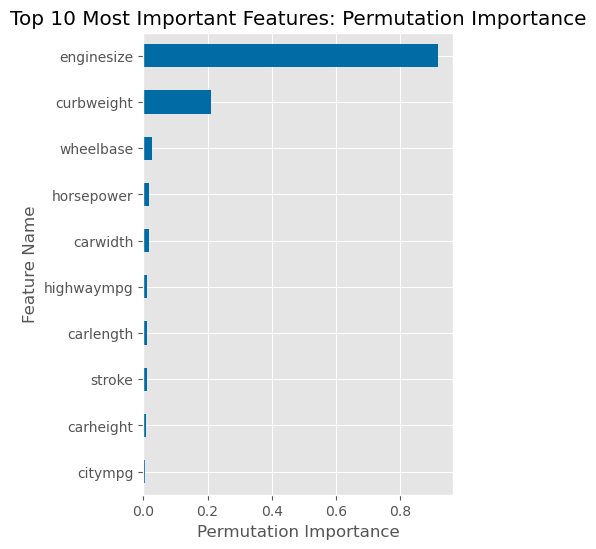

In [13]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

- Using permutation importance, the 5 most important features were: enginesize, curbweight, wheelbase, horsepower, and carwidt